## 1. Setup

### 1.1 Environment/Imports

In [17]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from scipy.sparse import hstack
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### 1.2 Read in data

In [2]:
dbase = '../assets/Preprocessed Data.xlsx'
data = pd.read_excel(dbase, sheet='Sheet1')

data.head()

,Author,Description,Long,Performance,Quality,Submission Date,Rating Date,One Year Date,Ticker,FDS Ticker,...,logPE,logPsales,logPFCF,logMKT,logEV,logROIC,MKT_category,Sentiment_polarity,Sentiment_subjectivity,Outperformed
1,Den1200,the purchase of BRK (and shorting out downsid...,True,3.9,2.6,2016-08-23,2016-09-06,2017-09-06,BRK.A,BRK.B,...,2.639003,0.489930,3.017299,12.813473,12.896157,1.999010,Large Cap,0.120324,0.429861,1
1,piggybanker,"that the stock of 1-800-Flowers.com, Inc (FLW...",True,4.3,4.0,2013-10-16,2013-10-30,2014-10-30,FLWS,FLWS,...,3.228965,-0.793357,4.770579,4.949525,5.995618,2.256795,Small Cap,0.131239,0.502589,1
2,shoon1022,"FLWS has an enterprise value of $215mm, but I...",True,3.4,3.8,2011-02-20,2011-03-06,2012-03-05,FLWS,FLWS,...,0.000000,-1.316094,0.000000,4.330223,5.381191,0.000000,Small Cap,0.103768,0.380808,0
3,xds68,2017\n \nRecommending Seaboard\nSeaboard is a ...,True,0.0,0.0,2016-08-23,2016-09-06,2017-09-06,SEB,SEB,...,2.635309,-0.474458,2.675116,8.234805,8.042525,2.034737,Medium Cap,0.063402,0.422381,1
3,u0422811,is pretty simple. Unfortunately due to its s...,False,5.2,4.9,2016-02-15,2016-02-29,2017-02-28,1PG,1PG-AU,...,0.000000,0.000000,0.000000,5.889505,5.603921,0.000000,Small Cap,0.121530,0.490904,0


### 1.3 Separate into long/short datasets

In [3]:
data_long = data[data['Long'] == True]
data_short = data[data['Long'] == False]

data_long = data_long[data_long['One Year Date']< datetime.now()]
data_short = data_short[data_short['One Year Date']< datetime.now()]

data_long = data_long[data_long['Outperformance'].notnull()]
data_short = data_short[data_short['Outperformance'].notnull()]

## 2. Random Forest Modeling and scoring

### 2.1 Set target

In [4]:
y = data_long['Outperformed']
descriptions = data_long['WordNet Desc']

### 2.2 Count Vectorizer

In [11]:
vectorizer = CountVectorizer(max_features = 2000, 
                             ngram_range=(2, 3), 
                             stop_words='english',
                             binary=False)

# Use 'fit' to learn the vocabulary of the titles
vectorizer.fit(descriptions)

# Use 'tranform' to generate the sample X word matrix - one column per feature (word or n-grams)
Count_Vectorizer_X = vectorizer.transform(descriptions)

In [12]:
model = RandomForestClassifier(n_estimators = 300)
scores = cross_val_score(model, Count_Vectorizer_X, y, scoring='roc_auc')
print ('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

# What features of these are most important?
model.fit(Count_Vectorizer_X, y)

all_feature_names = vectorizer.get_feature_names()
feature_importances = pd.DataFrame({'Features' : all_feature_names, 'Importance Score': model.feature_importances_})
feature_importances.sort_values('Importance Score', ascending=False).head()

CV AUC [ 0.54471484  0.53952096  0.55819874], Average AUC 0.547478183498


,Features,Importance Score
499,cash flow,0.003897
1169,long term,0.002713
1255,market cap,0.002675
866,ev ebitda,0.002650
929,free cash flow,0.002637


### 2.3 TF-IDF

In [13]:
#trying tf-idf
vectorizer = TfidfVectorizer(ngram_range=(2, 3), 
                             stop_words='english',
                             max_features = 3000)

#use 'fit' to learn the vocabulary
vectorizer.fit(descriptions)

#use 'tranform' to generate the sample X word matrix
TFIDF_X = vectorizer.transform(descriptions)#.toarray()

In [14]:
model = RandomForestClassifier(n_estimators = 300)
scores = cross_val_score(model, TFIDF_X, y, scoring='roc_auc')
print ('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

# What features of these are most important?
model.fit(TFIDF_X, y)

all_feature_names = vectorizer.get_feature_names()
feature_importances = pd.DataFrame({'Features' : all_feature_names, 'Importance Score': model.feature_importances_})
feature_importances.sort_values('Importance Score', ascending=False).head()

CV AUC [ 0.5512145   0.57313706  0.57417399], Average AUC 0.566175181805


,Features,Importance Score
757,cash flow,0.003604
2548,share price,0.002309
1371,free cash,0.002290
1372,free cash flow,0.002284
586,balance sheet,0.002220


### 2.4 Add other features to TF-IDF

In [9]:
# Identify the features wanted from the original dataset
other_features_columns = ['Quality','logMKT','logEV','Performance','logPE','logPFCF','logPsales','Sentiment_subjectivity','Sentiment_polarity']
other_features = data_long[other_features_columns]

# Stack them horizontally together
# This takes all of the word/n-gram columns and appends on more columns
from scipy.sparse import hstack
X = hstack((TFIDF_X, other_features))#.toarray()

In [15]:
model = RandomForestClassifier(n_estimators = 300)
scores = cross_val_score(model, X, y, scoring='roc_auc')
print ('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

CV AUC [ 0.56297091  0.56302661  0.56894143], Average AUC 0.564979650326


### 2.5 Parameter Tuning, GridSearchCV 

In [6]:
pipeline = Pipeline([
        ('tfidf',TfidfVectorizer()),
        ('model',RandomForestClassifier()),
    ])

parameters = {
    'tfidf__ngram_range':((2,3),(1,3)),
    'tfidf__max_features':(2000,3000,4000),
    'model__n_estimators':(200,300),
    'model__min_samples_leaf':(1,50)
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs = -1, verbose=1)
grid_search.fit(descriptions, y)

print "The best score received was: {}".format(grid_search.best_score_)
print "The parameters used were: {}".format(grid_search.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 35.7min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=Tru...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'model__min_samples_leaf': (1, 50), 'tfidf__max_features': (2000, 3000, 4000), 'model__n_estimators': (200, 300), 'tfidf__ngram_range': ((2, 3), (1, 3))},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [6]:
pipeline = Pipeline([
        ('tfidf',TfidfVectorizer(ngram_range=(1,3))),
        ('model',RandomForestClassifier()),
    ])

parameters = {
    'tfidf__max_features':(4000,5000),
    'model__n_estimators':(300,400),
    'model__min_samples_leaf':(1,3),
    'model__max_features':('auto',None)
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs = -1, verbose=2)
grid_search.fit(descriptions, y)

print "The best score received was: {}".format(grid_search.best_score_)
print "The parameters used were: {}".format(grid_search.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 76.7min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 154.7min finished


The best score received was: 0.577077747989
The parameters used were: {'model__min_samples_leaf': 1, 'model__max_features': 'auto', 'tfidf__max_features': 4000, 'model__n_estimators': 400}


## 3. Random Forest Predicting

### 3.1 Setup to use tuned parameters

In [5]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), 
                             stop_words='english',
                             max_features = 4000)

vectorizer.fit(descriptions)
TFIDF_X = vectorizer.transform(descriptions)#.toarray()

# Identify the features wanted from the original dataset
other_features_columns = ['Quality','logMKT','logEV','Performance','logPE','logPFCF','logPsales','Sentiment_subjectivity','Sentiment_polarity']
other_features = data_long[other_features_columns]

# Stack them horizontally together
# This takes all of the word/n-gram columns and appends on more columns
from scipy.sparse import hstack
X = hstack((TFIDF_X, other_features))#.toarray()

model = RandomForestClassifier(n_estimators = 400)

### 3.2 Define prediction process

In [12]:
def show_prediction_results(model, X, y, cv):
    predict_y = cross_val_predict(model, X, y, cv = cv)
    data_long['Predicted'] = predict_y
    data_predicted = data_long[data_long['Predicted']==1]
    
    print classification_report(y, predict_y)
    print
    print "Long write-ups average outperformance from model: {0:.2f}%".format(data_predicted['Outperformance'].mean()*100)
    print "Long write-ups average outperformance from website: {0:.2f}%".format(data_long['Outperformance'].mean()*100)
    print
    print 'Number of predicted Long write-ups is: {}'.format(len(data_predicted))
    print 'Number of original Long write-ups is: {}'.format(len(data_long))
    
    # Plot return distributions
    plt.figure()
    sns.distplot(data_long['Outperformance'],color='blue',label='All Long Ideas')
    sns.distplot(data_predicted['Outperformance'],color='red',label='Predicted Succesful Ideas')
    sns.plt.xlim(-2,4)
    sns.plt.legend()
    
    # Plot picks and performance over time
    timed_long = data_long[['One Year Date','Year Return','Year Index Return','Outperformance']].groupby('One Year Date').agg([np.mean,np.std,len]).reset_index()
    timed_predicted = data_predicted[['One Year Date','Year Return','Year Index Return','Outperformance']].groupby('One Year Date').agg([np.mean,np.std,len]).reset_index()
    date = timed_long['One Year Date']
    predicted_date = timed_predicted['One Year Date']

    performance_mean = np.array(timed_long['Year Return']['mean'])
    predicted_performance_mean = timed_predicted['Year Return']['mean']

    plt.figure()
    plt.title('Individual Absolute Stock Performance')
    plt.plot(date, performance_mean, '.', color = 'blue')
    plt.plot(predicted_date, predicted_performance_mean, '.', color = 'red')
    plt.xlabel('Date')
    plt.ylabel('Performance (one year returns)')
    plt.legend(['All long ideas', 'Predicted ideas'],loc='best',markerscale = 2) 
    
    # Show confusion matrix
    cm = confusion_matrix(y, predict_y)
    np.set_printoptions(precision=2)
    print
    print('Confusion matrix, without normalization')
    print(cm)

    # Normalize the confusion matrix by row
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print
    print('Normalized confusion matrix')
    print(cm_normalized)
    
    # Plot the confusion matrix
    def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
        plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        plt.xticks([0,1], rotation=45)
        plt.yticks([0,1])
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')


    # Compute confusion matrix
    plot_confusion_matrix(cm_normalized) 
    
    return

### 3.3 RF prediction w/ all features

             precision    recall  f1-score   support

          0       0.58      0.91      0.71      2564
          1       0.52      0.13      0.21      1912

avg / total       0.56      0.58      0.50      4476


Long write-ups average outperformance from model: 11.33%
Long write-ups average outperformance from website: 0.80%

Number of predicted Long write-ups is: 488
Number of original Long write-ups is: 4476

Confusion matrix, without normalization
[[2329  235]
 [1659  253]]

Normalized confusion matrix
[[ 0.91  0.09]
 [ 0.87  0.13]]


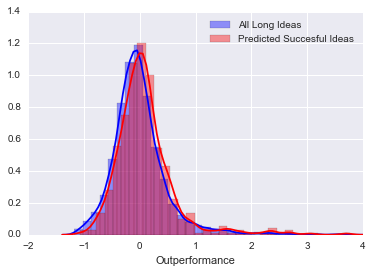

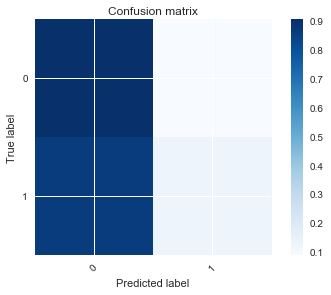

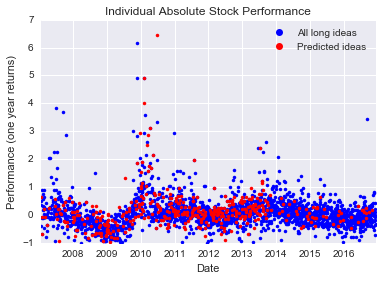

In [14]:
show_prediction_results(model, X, y, cv = 3)

### 3.4 RF prediction w/ text features only

             precision    recall  f1-score   support

          0       0.59      0.92      0.71      2564
          1       0.54      0.13      0.21      1912

avg / total       0.57      0.58      0.50      4476


Long write-ups average outperformance from model: 11.07%
Long write-ups average outperformance from website: 0.80%

Number of predicted Long write-ups is: 464
Number of original Long write-ups is: 4476

Confusion matrix, without normalization
[[2350  214]
 [1662  250]]

Normalized confusion matrix
[[ 0.92  0.08]
 [ 0.87  0.13]]


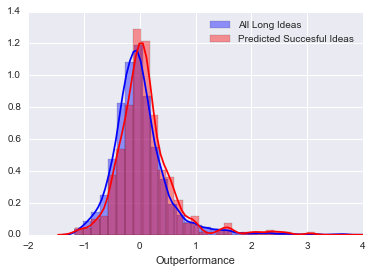

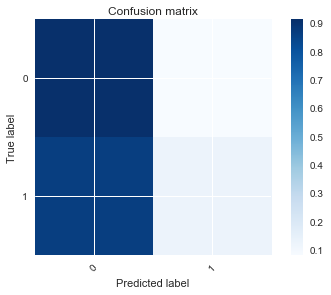

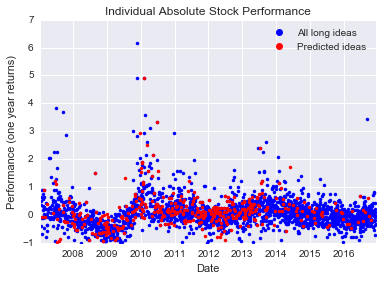

In [15]:
show_prediction_results(model, TFIDF_X, y, cv = 3)

## 4. Other classifier (MultinomialNB, GradientBoosting) modeling and scoring

In [39]:
multinb = MultinomialNB()
scores = cross_val_score(multinb, TFIDF_X, y, scoring='roc_auc')
print ('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

CV AUC [ 0.57  0.57  0.57], Average AUC 0.570619780905


In [37]:
gradient_boost = GradientBoostingClassifier()
scores = cross_val_score(gradient_boost, TFIDF_X.toarray(), y, scoring='roc_auc')
print ('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

CV AUC [ 0.55  0.51  0.52], Average AUC 0.529478584961


In [35]:
parameters = {
    'n_estimators':(150,200)}

grid_search = GridSearchCV(gradient_boost, parameters, n_jobs = -1, verbose=5)
grid_search.fit(TFIDF_X.toarray(), y)

print "The best score received was: {}".format(grid_search.best_score_)
print "The parameters used were: {}".format(grid_search.best_params_)

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  3.6min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  6.7min finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits
The best score received was: 0.548033958892
The parameters used were: {'n_estimators': 150}
